In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.metrics import silhouette_score

#### Description

In this project, you will practice techniques of Clustering under unsupervised machine learning using python with the Cambridge Crime Data dataset. The data contains a list of reported crimes in the annual crime report by the Cambridge police department from the year 2009 to 2016. The aim of the project is to divide the crimes into groups/clusters according to the crime type or crime column in the dataset and the neighborhood.

In [2]:
df_raw = pd.read_csv("Data/Cambridge Crime Data 2009-2016.csv")
df_raw.head(10)

,File Number,Date of Report,Crime Date Time,Crime,Reporting Area,Neighborhood,Location
0,2009-00002,01/01/2009 12:39:00 AM,1/1/09 0:39,Simple Assault,504.0,Cambridgeport,"400 Massachusetts Avenue, Cambridge, MA"
1,2009-00003,01/01/2009 01:34:00 AM,1/1/09 1:34,Simple Assault,610.0,Mid-Cambridge,"200 HAMPSHIRE STREET, Cambridge, MA"
2,2009-00004,01/01/2009 01:43:00 AM,01/01/2009 02:20 - 02:35,Aggravated Assault,708.0,Riverside,"DUNSTER STREET & MOUNT AUBURN STREET, Cambridg..."
3,2009-00005,01/01/2009 02:27:00 AM,01/01/2009 02:20 - 02:45,Simple Assault,105.0,East Cambridge,"100 SCIARAPPA STREET, Cambridge, MA"
4,2009-00006,01/01/2009 02:34:00 AM,01/01/2009 02:15 - 02:35,Disorderly,708.0,Riverside,"1200 Massachusetts Avenue, Cambridge, MA"
5,2009-00007,01/01/2009 02:45:00 AM,1/1/09 2:45,Missing Person,507.0,Cambridgeport,"0 WOODROW WILSON COURT, Cambridge, MA"
6,2009-00008,01/01/2009 02:37:00 AM,1/1/09 2:37,Mal. Dest. Property,1108.0,North Cambridge,"100 MONTGOMERY STREET, Cambridge, MA"
7,2009-00009,01/01/2009 10:42:00 AM,01/01/2009 10:30 - 10:42,Simple Assault,411.0,Area 4,"600 Massachusetts Avenue, Cambridge, MA"
8,2009-00010,01/01/2009 10:47:00 AM,01/01/2009 10:35 - 10:47,Shoplifting,1201.0,Highlands,"200 ALEWIFE BROOK PKY, Cambridge, MA"
9,2009-00011,01/01/2009 12:37:00 PM,12/31/2008 10:00 - 01/01/2009 10:00,Hit and Run,510.0,Cambridgeport,"FAIRMONT Avenue & Fairmont STREET, Cambridge, MA"


In [3]:
display(df_raw.info())
print("\n")
display(df_raw.isna().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56014 entries, 0 to 56013
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   File Number      56014 non-null  object 
 1   Date of Report   56014 non-null  object 
 2   Crime Date Time  56014 non-null  object 
 3   Crime            56014 non-null  object 
 4   Reporting Area   56012 non-null  float64
 5   Neighborhood     56012 non-null  object 
 6   Location         55931 non-null  object 
dtypes: float64(1), object(6)
memory usage: 3.0+ MB


None

File Number         0
Date of Report      0
Crime Date Time     0
Crime               0
Reporting Area      2
Neighborhood        2
Location           83
dtype: int64

In [4]:
df_raw.dropna(inplace=True)
display(df_raw.info())
print("\n")
display(df_raw.isna().sum())

<class 'pandas.core.frame.DataFrame'>
Index: 55929 entries, 0 to 56013
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   File Number      55929 non-null  object 
 1   Date of Report   55929 non-null  object 
 2   Crime Date Time  55929 non-null  object 
 3   Crime            55929 non-null  object 
 4   Reporting Area   55929 non-null  float64
 5   Neighborhood     55929 non-null  object 
 6   Location         55929 non-null  object 
dtypes: float64(1), object(6)
memory usage: 3.4+ MB


None

File Number        0
Date of Report     0
Crime Date Time    0
Crime              0
Reporting Area     0
Neighborhood       0
Location           0
dtype: int64

In [5]:
def kmeans_cluster_data(data):
    # K-Means
    inertias_log = {'k':[], 'inertia':[]}
    for k in range(2, 100):
        model = KMeans(n_clusters=k, init='k-means++', n_init='auto', max_iter=1000).fit(data)
        inertias_log['k'].append(k)
        inertias_log['inertia'].append(model.inertia_)

    #  Find best K automatically basd on inertia decrease at each K
    last_inertia = 1e16
    best_k = 0
    for i, current_inertia in enumerate(inertias_log['inertia']):

        k = inertias_log['k'][i]                  
        inertia_desc = (last_inertia-current_inertia) > 0
        inertia_decrease_perc = 100*(last_inertia-current_inertia)/last_inertia
        inertia_decrease_th = inertia_decrease_perc > 5
        last_inertia = current_inertia

        #print("K = ", k)
        #print("inertia_decrease_perc = ", inertia_decrease_perc)
        #print("last_inertia = ", last_inertia)
        #print("Inertia decrease = ", ((last_inertia-current_inertia)/last_inertia))

        if inertia_desc and inertia_decrease_th:
            best_k = k
        

    best_model = KMeans(n_clusters=best_k, init='k-means++', n_init='auto', max_iter=1000).fit(data)
    clustered_labels = best_model.labels_

    return clustered_labels, best_k, inertias_log

In [6]:
df = df_raw[['Crime', 'Neighborhood']]
display("Nr. Crime Types = ", len(df['Crime'].unique()))
display("Nr. Neighborhoods = ", len(df['Neighborhood'].unique()))

'Nr. Crime Types = '

54

'Nr. Neighborhoods = '

13

In [7]:
encoder = OneHotEncoder()
encoded_data = encoder.fit_transform(df.values)
clustered_labels, best_k, inertias_log = kmeans_cluster_data(encoded_data)

Text(0.5, 1.0, 'Elbow Plot\nBest K = 56')

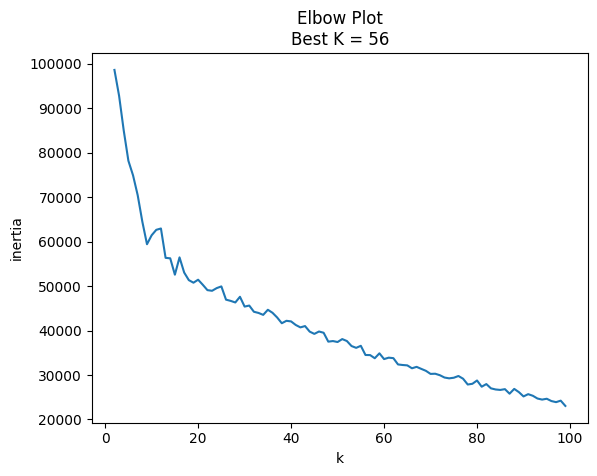

In [8]:
sns.lineplot(data=pd.DataFrame(inertias_log), x='k', y='inertia')
plt.title(f"Elbow Plot\nBest K = {best_k}")

In [9]:
#df_scatter = {'labels':clustered_labels, }